change kernel to venv 

choose interpreter venv/Scripts/python.exe

activate venv 

from readme 

Dataset Description

This dataset contains book synopsis. Your task is to classify the books into its respective genre based on the synopsis. Some of the synopsis contains nonsensical words, it would be your task to remove them. 
Make sure to divide the dataset into 80% train and 20% test set. Perform 5-fold cross validation on the training dataset to develop and choose your model. The remaining 20% should be kept only for testing the final model.

Class Information

'fantasy': 1,
'science': 2,
'crime': 3,
'history': 4,
'horror': 5,
'thriller': 6,
'psychology': 7,
'romance': 8,
'sports': 9,
'travel': 10

In [1]:
import re
import pandas as pd
import nltk
import langdetect
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer




nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt', quiet=True)

True

In [2]:
def remove_language_titles(text):
    """
    Removes language-specific titles or wiki-style foreign language tags 
    (e.g., 'fr:Mercredi sous les flots', 'th:พุธเพชฌฆาต').
    """
    if pd.isnull(text):
        return ""

    # Common patterns like 'fr:xxxx', 'de:xxxx', 'es:xxxx', etc.
    text = re.sub(r'\b[a-z]{2,3}:[^\s]+', '', text)

    # Remove standalone foreign alphabet text (non-ASCII)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    # Clean extra spaces after removal
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [3]:
def clean_basic(text):
    """
    Basic cleaning for visualisation and TF-IDF models.
    Includes lowercasing, URL removal, punctuation removal, and language title removal.
    """
    if pd.isnull(text):
        return ""

    # 1️⃣ Lowercase
    text = text.lower()

    # 2️⃣ Remove language tags and non-English text
    text = remove_language_titles(text)

    # 3️⃣ Remove URLs and non-alphabetic characters
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [4]:
books = pd.read_csv("data.csv")
print("✅ Dataset loaded successfully!")
print("Shape:", books.shape)
print(books.head())

✅ Dataset loaded successfully!
Shape: (4657, 2)
                                             summary  genre
0   Drowned Wednesday is the first Trustee among ...      1
1   As the book opens, Jason awakens on a school ...      1
2   Cugel is easily persuaded by the merchant Fia...      1
3   The book opens with Herald-Mage Vanyel return...      1
4   Taran and Gurgi have returned to Caer Dallben...      1


In [5]:
genre_map = {
    1: 'fantasy',
    2: 'science',
    3: 'crime',
    4: 'history',
    5: 'horror',
    6: 'thriller',
    7: 'psychology',
    8: 'romance',
    9: 'sports',
    10: 'travel'
}

books['class_information'] = books['genre'].map(genre_map)

print(books[['genre', 'class_information']].head())

   genre class_information
0      1           fantasy
1      1           fantasy
2      1           fantasy
3      1           fantasy
4      1           fantasy


In [6]:
books['clean_summary'] = books['summary'].apply(clean_basic)

C:\Users\jacel\AppData\Local\Temp\ipykernel_7256\3067394231.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=books, x='class_information', order=books['class_information'].value_counts().index, palette='viridis')


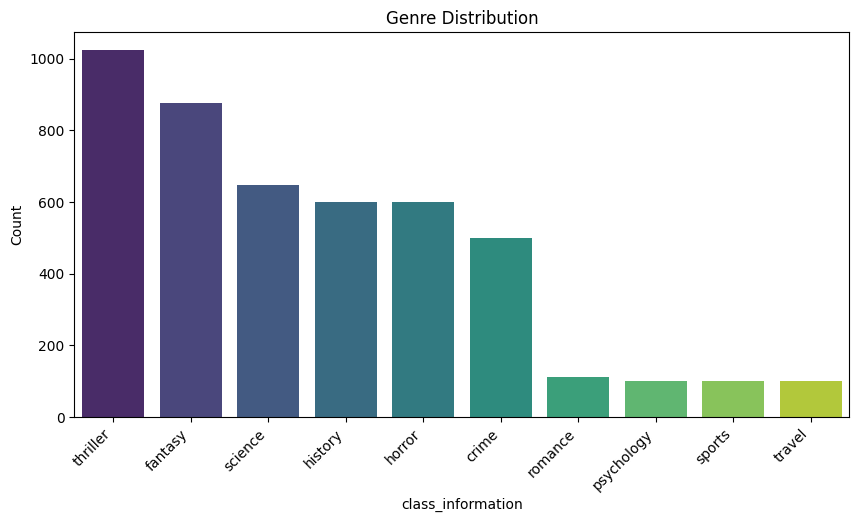

In [7]:

plt.figure(figsize=(10,5))
sns.countplot(data=books, x='class_information', order=books['class_information'].value_counts().index, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Genre Distribution')
plt.xlabel('class_information')
plt.ylabel('Count')
plt.show()

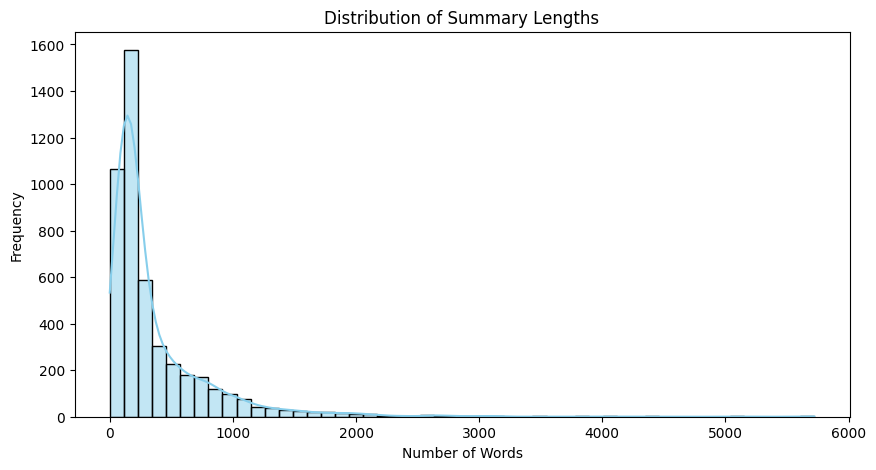

In [8]:
books['summary_length'] = books['clean_summary'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
sns.histplot(books['summary_length'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Summary Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [9]:
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

def lematizing(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = lemma.lemmatize(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

In [10]:
stop_words = set(stopwords.words('english'))

from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0  # ensure consistent language detection

foreign_stopwords = {"le", "la", "de", "el", "les", "des", "du", "en", "un", "une", "et", "pour"}

def clean_deep(text):
    """
    Deep cleaning for model training (TF-IDF, LSTM, BERT fine-tuning).
    Includes:
    - Lowercasing
    - Language tag removal
    - Stopword + foreign word removal
    - Lemmatization
    - English-only filtering
    """
    if pd.isnull(text):
        return ""

    text = clean_basic(text)

    # Detect language — skip if not English
    try:
        if detect(text) != "en":
            return ""
    except:
        return ""  # skip if detection fails

    # Remove English + foreign stopwords
    words = [
        word for word in text.split()
        if word not in stop_words and word not in foreign_stopwords
    ]
    text = " ".join(words)

    # Apply lemmatization
    text = lematizing(text)

    text = re.sub(r'\ble\b', ' ', text)  # remove standalone 'le'
    text = re.sub(r'\s+', ' ', text).strip()

    return text.strip()

In [11]:
books["clean_summary_deep"] = books["summary"].apply(clean_deep)

splitting dataset

In [12]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    books,
    test_size=0.2,
    random_state=42,
    stratify=books["class_information"]
)

print(f"Training set: {train_df.shape}")
print(f"Testing set: {test_df.shape}")

Training set: (3725, 6)
Testing set: (932, 6)


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2)
)

X_train_tfidf = vectorizer.fit_transform(train_df["clean_summary_deep"])
X_test_tfidf = vectorizer.transform(test_df["clean_summary_deep"])

y_train = train_df["class_information"]
y_test = test_df["class_information"]


bert embedding -> dimensionality reduction 

In [15]:
# ---- BERT Embedding (PyTorch version) ----
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)
model.eval()  # put model in evaluation mode (no dropout)

def bert_batch_embed(texts, tokenizer, model, batch_size=8, max_length=256):
    all_embeddings = []
    with torch.no_grad():  # disable gradient calculations
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            encodings = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
            outputs = model(**encodings)
            # Take mean of last hidden states across sequence dimension
            emb = outputs.last_hidden_state.mean(dim=1).numpy()
            all_embeddings.append(emb)
            print(f"Processed batch {i // batch_size + 1}/{(len(texts) + batch_size - 1) // batch_size}")
    return np.vstack(all_embeddings)

X_train_embed = bert_batch_embed(list(train_df["clean_summary_deep"]), tokenizer, model)
X_test_embed  = bert_batch_embed(list(test_df["clean_summary_deep"]), tokenizer, model)

print("✅ Embeddings created successfully")
print("Train embeddings shape:", X_train_embed.shape)
print("Test embeddings shape:", X_test_embed.shape)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
c:\Users\jacel\Desktop\IT1244\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jacel\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: htt

Processed batch 1/466
Processed batch 2/466
Processed batch 3/466
Processed batch 4/466
Processed batch 5/466
Processed batch 6/466
Processed batch 7/466
Processed batch 8/466
Processed batch 9/466
Processed batch 10/466
Processed batch 11/466
Processed batch 12/466
Processed batch 13/466
Processed batch 14/466
Processed batch 15/466
Processed batch 16/466
Processed batch 17/466
Processed batch 18/466
Processed batch 19/466
Processed batch 20/466
Processed batch 21/466
Processed batch 22/466
Processed batch 23/466
Processed batch 24/466
Processed batch 25/466
Processed batch 26/466
Processed batch 27/466
Processed batch 28/466
Processed batch 29/466
Processed batch 30/466
Processed batch 31/466
Processed batch 32/466
Processed batch 33/466
Processed batch 34/466
Processed batch 35/466
Processed batch 36/466
Processed batch 37/466
Processed batch 38/466
Processed batch 39/466
Processed batch 40/466
Processed batch 41/466
Processed batch 42/466
Processed batch 43/466
Processed batch 44/4

In [16]:
# ---- PCA Dimensionality Reduction + Dataset Prep ----
from sklearn.decomposition import PCA
import joblib
import numpy as np

# Dimensionality reduction
pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train_embed)
X_test_pca  = pca.transform(X_test_embed)

print("✅ PCA complete")
print("Train PCA shape:", X_train_pca.shape)
print("Test PCA shape:", X_test_pca.shape)
print("Explained variance ratio:", round(pca.explained_variance_ratio_.sum(), 4))

# Save outputs for DL models
np.save("X_train_pca.npy", X_train_pca)
np.save("X_test_pca.npy",  X_test_pca)
np.save("y_train.npy", train_df["class_information"].to_numpy())
np.save("y_test.npy",  test_df["class_information"].to_numpy())
joblib.dump(pca, "pca_model.joblib")

print("💾 Saved:")
print(" - X_train_pca.npy / X_test_pca.npy")
print(" - y_train.npy / y_test.npy")
print(" - pca_model.joblib (for reproducibility)")


✅ PCA complete
Train PCA shape: (3725, 100)
Test PCA shape: (932, 100)
Explained variance ratio: 0.88
💾 Saved:
 - X_train_pca.npy / X_test_pca.npy
 - y_train.npy / y_test.npy
 - pca_model.joblib (for reproducibility)


verifying preprocessing artifacts 

In [18]:
import numpy as np
import joblib

X_train = np.load("X_train_pca.npy")
X_test  = np.load("X_test_pca.npy")
y_train = np.load("y_train.npy", allow_pickle=True)   # <-- allow_pickle=True
y_test  = np.load("y_test.npy", allow_pickle=True)    # <-- allow_pickle=True
pca_model = joblib.load("pca_model.joblib")

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


Shapes:
X_train: (3725, 100) y_train: (3725,)
X_test: (932, 100) y_test: (932,)


In [19]:
print("y_train sample:", y_train[:5])
print("Type of y_train element:", type(y_train[0]))


y_train sample: ['fantasy' 'history' 'romance' 'crime' 'thriller']
Type of y_train element: <class 'str'>


encoding labels numerically before training scikit-learn models

In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)
